# ![](https://www.northwell.edu/sites/northwell.edu/files/northwell-logo-horizontal.png) 

# Covid Predictor Using Web Traffic Data 

This notebook was created in July 2020 as a response to the Covid-19 Pandemic. The ensuing model was operationalized and is used in operational planning for upticks in expected Covid cases in the Northwell Health system.


The analysis and model follow these steps:
 - Take a feed of Covid positive diagnoses from clinical systems
 - Injest web traffic data from Google Analytics, via Google Big Query for use as independent variables
 - Feature engineer web traffic data into salient categories, then normalize
 - Index covid cases data into bins
 - Evaluate predictive potential of web traffic to covid cases

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm


%matplotlib inline

## 0- Injest Covid Case count from Hospital Systems

In [2]:
covid = pd.read_csv('cases.csv',parse_dates = ['date'])
covid.set_index('date',inplace=True)

In [3]:
covid.head()

,cases
date,
2020-03-02,4
2020-03-03,3
2020-03-04,3
2020-03-05,3
2020-03-06,1


In [4]:
covid.describe()

,cases
count,198.000000
mean,93.191919
std,121.066133
min,1.000000
25%,19.000000
50%,44.000000
75%,109.250000
max,586.000000


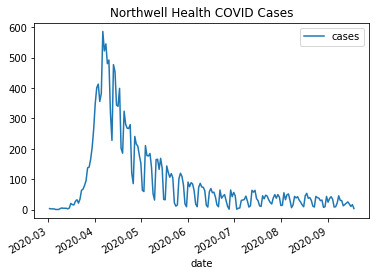

In [5]:
covid.plot(title = 'Northwell Health COVID Cases')

## 1- Covid Cases and Big Query Data: Cleaning

In [52]:
#The script called 'web_input_data_v3 _from_BQ.sql' was used to create this CSV from Big Query GA data

bq_data = pd.read_csv('bigquery_data_for_covid_regression 20200922.csv', parse_dates=['date'])
bq_data.set_index('date',inplace=True)
bq_data.head()

,pageViews,doc_profile_pv,req_app_successful_form_submit,covid_page,fad_general,wait_time,doc_care_loc,fad_req_app,contact_link_click,click_to_call,visitation_page,go_health_visit,hospital_loc,get_directions,feinstein_visit,doc_care_loc_clinics
date,,,,,,,,,,,,,,,,
2020-02-15,48639,6016,93,367,6983,198,1125,31,620,515,741,26,209,65,2,16
2020-02-16,47584,5866,74,266,6765,237,935,41,391,306,655,29,129,66,3,3
2020-02-17,98430,18219,220,400,21129,167,2511,107,2621,2358,1003,27,404,275,11,38
2020-02-18,97598,17247,222,167,20163,174,2418,96,2234,1995,1040,24,435,254,13,14
2020-02-19,93672,16633,181,196,19543,208,2317,101,2024,1784,942,39,374,264,11,20


In [53]:
bq_data.describe()

,pageViews,doc_profile_pv,req_app_successful_form_submit,covid_page,fad_general,wait_time,doc_care_loc,fad_req_app,contact_link_click,click_to_call,visitation_page,go_health_visit,hospital_loc,get_directions,feinstein_visit,doc_care_loc_clinics
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,98545.125000,11669.809524,256.922619,33685.672619,13502.476190,349.845238,1894.922619,272.369048,1522.309524,1329.934524,2189.077381,55.065476,244.416667,142.732143,16.142857,16.690476
std,26817.881001,5213.590538,204.204342,29152.130501,6045.347473,206.205728,891.512521,293.249900,753.523428,690.828827,2473.152961,27.780608,134.364970,77.390485,9.620516,14.274869
min,41132.000000,4130.000000,50.000000,30.000000,4731.000000,122.000000,479.000000,0.000000,287.000000,222.000000,595.000000,12.000000,36.000000,29.000000,1.000000,0.000000
25%,81508.500000,7707.250000,105.000000,11968.250000,8901.750000,226.500000,1250.500000,35.750000,695.500000,553.500000,1036.250000,34.000000,139.500000,77.000000,10.000000,7.000000
50%,101192.000000,10573.000000,189.000000,29167.500000,12276.500000,285.000000,2039.500000,117.000000,1610.500000,1393.000000,1502.500000,50.000000,211.000000,116.500000,14.000000,14.000000
75%,118921.000000,15937.000000,356.000000,46962.250000,18492.000000,370.250000,2258.750000,472.750000,2072.750000,1843.000000,2232.250000,70.000000,335.250000,212.500000,21.250000,22.000000
max,159064.000000,22610.000000,1123.000000,170184.000000,27089.000000,1166.000000,8520.000000,1094.000000,3383.000000,3007.000000,19397.000000,154.000000,775.000000,303.000000,60.000000,94.000000


In [54]:
#Create Z-score of the dataframe
bq_data =(bq_data - bq_data.mean())/bq_data.std()
bq_data.head()

,pageViews,doc_profile_pv,req_app_successful_form_submit,covid_page,fad_general,wait_time,doc_care_loc,fad_req_app,contact_link_click,click_to_call,visitation_page,go_health_visit,hospital_loc,get_directions,feinstein_visit,doc_care_loc_clinics
date,,,,,,,,,,,,,,,,
2020-02-15,-1.860927,-1.084437,-0.802738,-1.142924,-1.078429,-0.736377,-0.863614,-0.823083,-1.197454,-1.179648,-0.585519,-1.046251,-0.263586,-1.004415,-1.470073,-0.048370
2020-02-16,-1.900267,-1.113208,-0.895782,-1.146389,-1.114489,-0.547246,-1.076735,-0.788983,-1.501359,-1.482183,-0.620292,-0.938262,-0.858979,-0.991493,-1.366128,-0.959061
2020-02-17,-0.004293,1.256177,-0.180812,-1.141792,1.261553,-0.886713,0.691047,-0.563919,1.458071,1.488162,-0.479581,-1.010254,1.187686,1.709097,-0.534572,1.492800
2020-02-18,-0.035317,1.069741,-0.171018,-1.149785,1.101760,-0.852766,0.586730,-0.601429,0.944484,0.962707,-0.464620,-1.118243,1.418400,1.437746,-0.326683,-0.188476
2020-02-19,-0.181712,0.951972,-0.371797,-1.148790,0.999202,-0.687882,0.473440,-0.584379,0.665793,0.657276,-0.504246,-0.578298,0.964413,1.566961,-0.534572,0.231843


## 2- Merge Web Data and Covid Case Data

In [55]:
covid_bq_data = pd.merge(covid, bq_data, on = 'date', how = 'inner')
covid_bq_data.head()

,cases,pageViews,doc_profile_pv,req_app_successful_form_submit,covid_page,fad_general,wait_time,doc_care_loc,fad_req_app,contact_link_click,click_to_call,visitation_page,go_health_visit,hospital_loc,get_directions,feinstein_visit,doc_care_loc_clinics
date,,,,,,,,,,,,,,,,,
2020-03-02,4,-0.953622,0.070046,-0.298341,-1.153764,0.036478,-1.007951,-0.456441,-0.574149,0.574223,0.651486,-0.560854,-0.902265,-0.271028,0.080990,-1.158239,-0.608796
2020-03-03,3,0.094783,1.097745,-0.195503,-1.151843,1.125249,-0.818819,0.500360,-0.560508,1.501865,1.460659,-0.450468,-0.686287,1.314207,1.877076,-0.742461,1.492800
2020-03-04,3,-0.154566,0.827873,-0.508915,-1.153386,0.856117,-0.910960,0.375853,-0.635530,0.651195,0.650039,-0.511928,-0.866269,0.971855,1.347296,-0.326683,0.932374
2020-03-05,3,-0.130328,0.720653,-0.376694,-1.150608,0.761995,3.662143,0.382583,-0.655990,0.444167,0.463306,-0.513950,-1.118243,0.949528,1.437746,-0.326683,0.371949
2020-03-06,1,-0.555530,0.318243,-0.504018,-1.151809,0.317025,0.529349,-0.030199,-0.703731,0.259701,0.195512,-0.557619,-1.514203,0.235056,0.442792,-0.430627,0.652162


In [56]:
covid_bq_data.describe()

,cases,pageViews,doc_profile_pv,req_app_successful_form_submit,covid_page,fad_general,wait_time,doc_care_loc,fad_req_app,contact_link_click,click_to_call,visitation_page,go_health_visit,hospital_loc,get_directions,feinstein_visit,doc_care_loc_clinics
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,113.350993,0.110876,-0.005191,0.061543,0.128502,-0.006749,0.088203,0.025626,0.078009,0.010786,0.009259,0.060663,0.120889,-0.033807,-0.042320,0.087030,-0.024246
std,132.135193,0.954847,0.998422,1.033337,0.974174,0.997780,1.016203,1.014214,1.025405,0.986652,0.988206,1.037374,0.979713,1.008816,0.976695,1.007241,1.024089
min,1.000000,-1.933230,-1.446184,-1.013312,-1.154484,-1.450947,-1.007951,-1.588225,-0.928795,-1.639378,-1.603776,-0.634848,-1.550199,-1.551124,-1.469588,-1.574017,-1.169221
25%,23.500000,-0.396270,-0.704564,-0.734179,-0.503503,-0.738084,-0.498751,-0.667879,-0.809443,-1.015641,-1.043579,-0.408417,-0.506306,-0.795718,-0.849357,-0.638516,-0.678849
50%,60.000000,0.207804,-0.233775,-0.293444,-0.080703,-0.213135,-0.222328,0.163853,-0.185402,0.111066,0.078262,-0.229698,-0.110346,-0.263586,-0.410026,-0.118794,-0.258530
75%,159.000000,0.834606,0.773400,0.578231,0.531190,0.751739,0.148661,0.406699,0.822271,0.728830,0.742681,0.042020,0.573584,0.547638,0.772289,0.712763,0.371949
max,586.000000,2.256661,2.098398,4.241229,4.682276,2.247435,3.957964,7.431278,2.801812,2.469320,2.427614,6.957889,3.561280,3.948822,2.070899,4.558710,5.415778


## 3-Create bins of cases

In [57]:
#create bins of cases
bin_labels = [0,1,2,3,4,5,6,7,8,9]

covid_bq_data['cases'] = pd.qcut(covid_bq_data["cases"],
                              q=10,
                              labels=bin_labels)

covid_bq_data["cases"] = covid_bq_data["cases"].astype('float64')

## 4- Create Model and Predict

In [58]:
from sklearn.linear_model import LogisticRegression

X = covid_bq_data.drop(columns=['cases'])
y = covid_bq_data['cases']
clf = LogisticRegression(random_state=0).fit(X, y)

In [59]:
clf.score(X,y)

0.695364238410596

Text(0.5, 1.0, 'Covid Case Decile Prediction versus Actual')

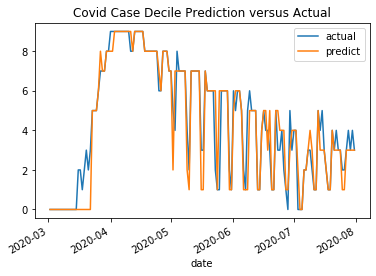

In [60]:
pd.DataFrame({'actual':y,'predict':clf.predict(X)}).plot()
plt.title('Covid Case Decile Prediction Versus Actual')